## 1. 모듈 임포트

In [28]:
from scipy import fftpack  # 고속 푸리에 변환
from scipy import signal

import scipy.io.wavfile  # WAV 유형 오디오 파일
from scipy import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

## 2. 스펙트럼 분석
: 신호를 시간 영역 --> 주파수 영역 변환  
==> 우세한 주파수 성분의 특징 추출, 신호에 필터 적용, 미분 방정식 해결 

### 푸리에 변환

In [29]:
# 1Hz, 22Hz의 순수 사인 성분을 가진 신호에 대한 잡음 표본 생성
def signal_samples(t):
  return (2 * np.sin(1 * 2 * np.pi + t) + 3 * np.sin(22 * 2 * np.pi * t) + 2 * np.random.randn(*np.shape(t)))

In [30]:
B = 30.0  # 계산하고자 하는 주파수 30Hz로 가정
f_s = 2 * B  # 샘플링 주파수 60Hz로 선택
delta_f = 0.01  # 얻고자 하는 주파수의 분해능 0.01.Hz
N = int(f_s / delta_f); N  # 필요한 표본 개수 = (샘플링 주파수)/(얻고자 하는 주파수의 분해능)

6000

In [31]:
T = N / f_s; T  # 표본 주기 = (표본 개수)/(샘플링 주파수)

100.0

In [32]:
# 신호 함수 추출
t = np.linspace(0, T, N)  # 표본 추출 시간을 가진 배열 생성
f_t = signal_samples(t)  # signal_samples 함수 계산

Text(0.5, 0, 'time (s)')

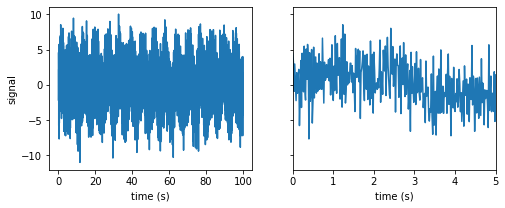

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")

# 랜덤 노이즈를 추가한 전체 신호, 초기 시간 동안의 확대 신호

In [34]:
# 신호의 사인 성분 추출
F = fftpack.fft(f_t)  # fft 함수를 이산 표본 배열에 적용 --> 이산 퓨리에 변환 
f = fftpack.fftfreq(N, 1.0/f_s)   # 표본개수와 표본 추출 사이의 지속시간으로 주파수 빈 획득

In [35]:
mask = np.where(f >= 0)  # 양의 주파수 성분을 선택하기 위한 마스크 생성

Text(0, 0.5, '$\\log(|F|)$')

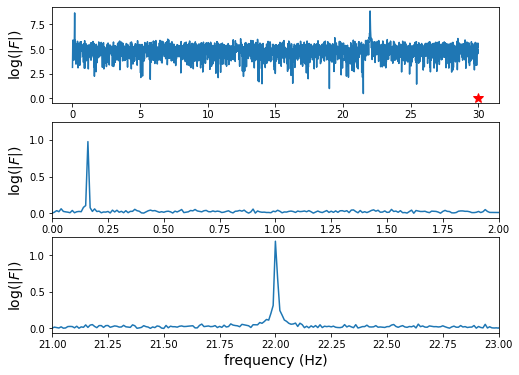

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)
axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$\log(|F|)$", fontsize=14)
axes[2].plot(f[mask],abs(F[mask])/N, label="real")
axes[2].set_xlim(21, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$\log(|F|)$", fontsize=14)

# 전체 양의 주파수 스펙트럼 --> 신호의 사인파 성분인 1, 22Hz의 피크 확인
# 1Hz 피크 확대
# 22Hz 피크 확대

#### 주파수-영역 필터

In [37]:
# 역 푸리에 변환
F_filtered = F * (abs(f) < 2)  # 2Hz 미만의 주파수만 선택하는 저주파통과  필터 적용
f_t_filtered = fftpack.ifft(F_filtered)  # ifft: 역 퓨리에 변환

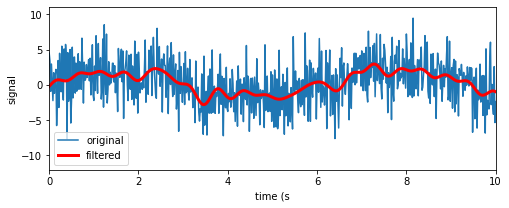

In [38]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='original')
ax.plot(t, f_t_filtered.real, color = "red", lw=3, label='filtered')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s")
ax.set_ylabel("signal")
ax.legend()

# 고주파 진동이 없는 시간영역의 신호 생성

### 윈도우
: 신호가 곱해지면 크기를 조절해 샘플링 주기의 처음과 마지막 부분을 0에 가깝게 만드는 함수.  
--> 신호에 FFT를 직접 적용하는 것이 아니라 윈도우 함수를 먼저 적용  
- Blackman
- Hann
- Hamming
- Gaussian
- Kaiser, etc.  

목적  
: 샘플링 주기와 정확히 구분되지 않는 신호 구성요소를 가진 신호를 DFT할 경우에 발생하는 주파수 빈 사이의 스펙트럼 누출을 줄이는 것.

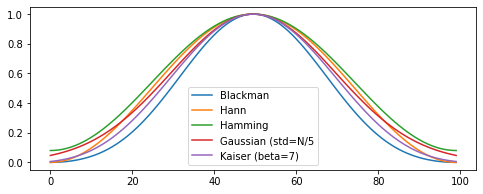

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")
ax.legend(loc=0)

# 다양한 윈도우 함수들의 전체적인 모양이 유사함.

예제) 실외 온도 측정

In [40]:
df = pd.read_csv('/temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])  # 데이터 로드
df.time = (pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm'))  # 등간격으로 재표본
df = df.set_index("time")
df = df.resample("H").ffill()    # ffill(); 요소 집계
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

In [41]:
# 시계열 데이터 처리를 위한 Numpy 배열 추출
time = df.index.astype('int64')/1.0e9
temperature = df.temperature.values 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns, Europe/Stockholm] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [42]:
window = signal.blackman(len(temperature))  # FFT 계산 전 데이터에 블랙만 윈도우 함수 적용

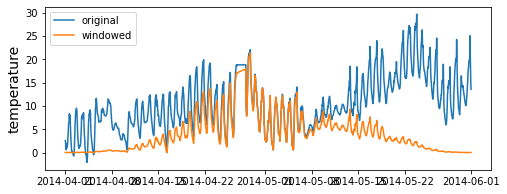

In [43]:
temperature_windowed = temperature * window
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original")
ax.plot(df.index, temperature_windowed, label="windowed")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

# blue = 원래의 온도 시계열
# orange = 윈도우 된 버전 
# --> 샘플링 주기 경계 부근에서 0에 근접하는 신호 = 주기 경계 간 전환이 원활해진다.

In [44]:
# 전과 같은 스펙트럼 분석
data_fft_windowed = fftpack.fft(temperature_windowed)  # 이산 퓨리에 변환
f = fftpack.fftfreq(len(temperature), time[1]-time[0])  # 주파수 빈 획득

Text(0.5, 0, 'frequency (Hz)')

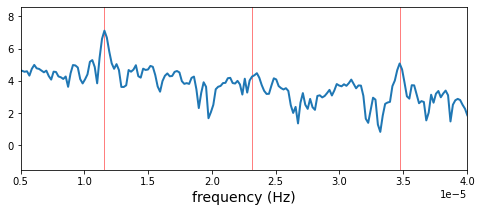

In [45]:
mask = f > 0  # 마스크로 양의 주파수 선택
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0.000005, 0.00004)
ax.axvline(1./86400, color='r',lw=0.5)
ax.axvline(2./86400, color='r',lw=0.5)
ax.axvline(3./86400, color='r',lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])), lw=2)
ax.set_xlabel("$log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)

# 1일 주기에 해당하는 주파수의 뚜렷한 피크와 상위 조화파

### 스펙트로그램

In [46]:
sample_rate, data = io.wavfile.read("/guitar.wav")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [47]:
sample_rate

44100

In [48]:
data.shape

(189449, 2)

In [49]:
data = data.mean(axis=1)

In [50]:
data.shape[0] / sample_rate

4.295895691609977

In [51]:
N = int(sample_rate/2.0)  # 0.5초 --> 22050 표본

In [52]:
f = fftpack.fftfreq(N, 1.0/sample_rate)
t = np.linspace(0, 0.5, N)
mask = (f > 0) * (f < 1000)

In [53]:
subdata = data[:N]
F = fftpack.fft(subdata)

Text(0.5, 0, 'Frequency (Hz)')

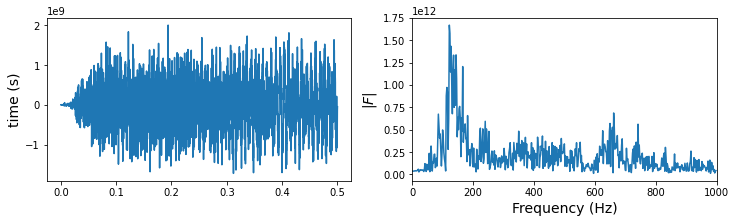

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_ylabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)

In [55]:
n_max = int(data.shape[0] / N)
f_values = np.sum(mask)
spectogram_data = np.zeros((n_max, f_values))

In [56]:
window = signal.blackman(len(subdata))

In [57]:
for n in range(0, n_max):
  subdata = data[(N * n):(N * (n + 1))]
  F = fftpack.fft(subdata * window)
  spectogram_data[n, :] = np.log(abs(F[mask]))

Text(0.5, 0, 'Frequency (Hz)')

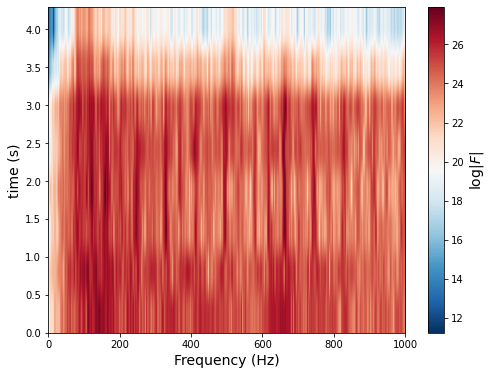

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spectogram_data, origin='lower', extent=(0, 1000, 0, data.shape[0] / sample_rate), aspect='auto', cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=14)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)

## 신호 필터

### 컨볼루션 필터

In [59]:
t = np.linspace(0, T, N)
f_t = signal_samples(t)
H = abs(f) < 2
h = fftpack.fftshift(fftpack.ifft(H))
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

ValueError: ignored

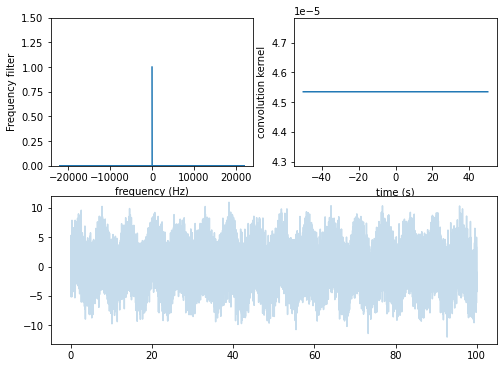

In [60]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)
ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - t[-1]/2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")
ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, 'r', lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

### FIR 및 IIR 필터

In [61]:
n = 101
f_s = 1 / 3600
nyq = f_s/2
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

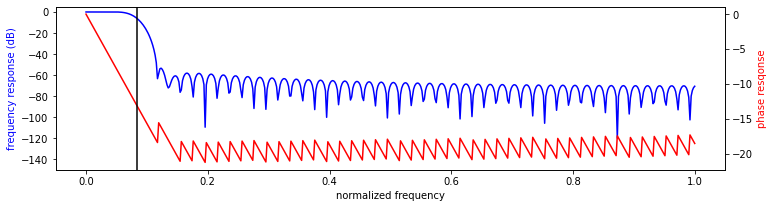

In [62]:
f, h = signal.freqz(b)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase resqonse', color="r")
ax.axvline(1.0/12, color='black')

In [63]:
temperature_filt = signal.lfilter(b, 1, temperature)

In [64]:
temperature_median_filt = signal.medfilt(temperature, 25)

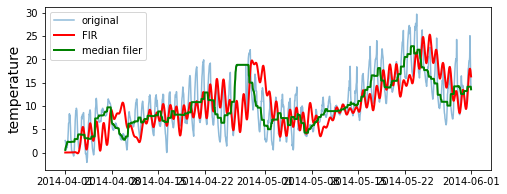

In [65]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filt, color="red", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filt, color="green", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

In [66]:
b, a = signal.butter(2, 7/365.0, btype='high')

In [67]:
b

array([ 0.95829139, -1.91658277,  0.95829139])

In [68]:
a

array([ 1.        , -1.91484241,  0.91832314])

In [69]:
temperature_iir = signal.lfilter(b, a, temperature)

In [70]:
temperature_filtfilt = signal.filtfilt(b, a, temperature)

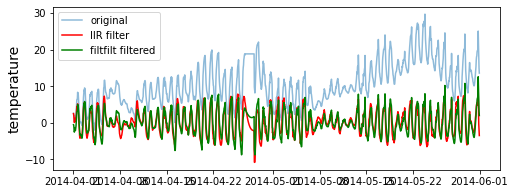

In [71]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtfilt, color="green", label="filtfilt filtered")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

In [72]:
b = np.zeros(10000)
b[0] = b[-1] = 1
b /= b.sum()
data_filt = signal.lfilter(b, 1, data)

In [73]:
io.wavfile.write("guitar-echo.wav", sample_rate, np.vstack([data_filt, data_filt]).T.astype(np.int16))